In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

## dataset

In [66]:
ratebeer = pd.read_json("../data/ratebeer_korea.json")

In [67]:
ratebeer.tail()

,reviewScore,reviewTime,reviewText,appearance,aroma,palate,taste,overall,profileName,beerName,beerID,brewerID,ABV,style,imageUrl
94316,3.0,2000-06-14 04:58:02.000,"pale clear golden colour with a fine head, low...",4.0,5.0,3.0,6.0,12.0,Bov,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
94317,4.2,2000-06-10 16:51:58.000,"love that skunky smell ! Actually, my fav eve...",4.0,9.0,4.0,8.0,17.0,sallyclub99,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
94318,2.7,2000-06-05 08:46:21.000,Much better than American pilsners which isn't...,2.0,5.0,2.0,6.0,12.0,kublai3,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
94319,3.3,2000-06-03 23:59:02.000,"A decent, light-German beer. Not bad, but then...",3.0,6.0,3.0,6.0,15.0,Aubrey,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
94320,3.3,2000-05-07 01:07:31.000,Beck's is a decent german beer. It's a little...,3.0,6.0,4.0,7.0,13.0,roland,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...


In [68]:
ratebeer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93623 entries, 0 to 94320
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   reviewScore  93620 non-null  float64
 1   reviewTime   93623 non-null  object 
 2   reviewText   93623 non-null  object 
 3   appearance   92036 non-null  float64
 4   aroma        92036 non-null  float64
 5   palate       92036 non-null  float64
 6   taste        92036 non-null  float64
 7   overall      92036 non-null  float64
 8   profileName  93623 non-null  object 
 9   beerName     93623 non-null  object 
 10  beerID       93623 non-null  int64  
 11  brewerID     93623 non-null  int64  
 12  ABV          93623 non-null  float64
 13  style        93623 non-null  object 
 14  imageUrl     93623 non-null  object 
dtypes: float64(7), int64(2), object(6)
memory usage: 11.4+ MB


In [69]:
# 결측치 제거
ratebeer = ratebeer.dropna(subset=['reviewScore']).reset_index(drop = True)
ratebeer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93620 entries, 0 to 93619
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   reviewScore  93620 non-null  float64
 1   reviewTime   93620 non-null  object 
 2   reviewText   93620 non-null  object 
 3   appearance   92036 non-null  float64
 4   aroma        92036 non-null  float64
 5   palate       92036 non-null  float64
 6   taste        92036 non-null  float64
 7   overall      92036 non-null  float64
 8   profileName  93620 non-null  object 
 9   beerName     93620 non-null  object 
 10  beerID       93620 non-null  int64  
 11  brewerID     93620 non-null  int64  
 12  ABV          93620 non-null  float64
 13  style        93620 non-null  object 
 14  imageUrl     93620 non-null  object 
dtypes: float64(7), int64(2), object(6)
memory usage: 10.7+ MB


In [70]:
# # coldstart ID 생성
# style_dict = {
#     'Amber Lager - International / Vienna':0,
#     'Apple Cider':1,
#     'Belgian Ale - Dark / Amber':2,
#     'Belgian Ale - Pale / Golden / Single':3,
#     'Dark Lager - Dunkel / Tmavý':4,
#     'Dark Lager - International / Premium':5,
#     'Flavored - Fruit':6,
#     'Flavored - Other':7,
#     'IPA':8,
#     'IPA - English':8,
#     'Low / No Alcohol Beer - Pale':9,
#     'Märzen / Oktoberfest Bier':10,
#     'Pale Ale - American (APA)':11,
#     'Pale Ale - English':11,
#     'Pale Lager - American':12,
#     'Pale Lager - International / Premium':12,
#     'Pilsener - Bohemian / Czech':13,
#     'Pilsener - Imperial':13,
#     'Pilsener / Pils / Pilsner':13,
#     'Radler / Shandy':14,
#     'Stout':14,
#     'Weissbier - Dunkelweizen':15,
#     'Weissbier - Hefeweizen':15,
#     'Wheat Ale':16,
#     'Witbier / Belgian White Ale':17,
#     'Zwickelbier / Kellerbier / Landbier':18
# }
# ratebeer['label'] = ratebeer['style'].apply(lambda x : style_dict[x])

In [71]:
ratebeer

,reviewScore,reviewTime,reviewText,appearance,aroma,palate,taste,overall,profileName,beerName,beerID,brewerID,ABV,style,imageUrl
0,1.3,2021-02-27 12:53:53.373,Small can from Valencia. Thanks Mario for this...,2.0,1.0,1.0,3.0,6.0,Grzesiek79,Eichbaum Apostel Bräu,75661,1103,5.0,Pilsener / Pils / Pilsner,https://res.cloudinary.com/ratebeer/image/uplo...
1,2.7,2021-01-08 18:06:32.240,"Ar: slod, niska intensywnosc, sladowy slod. Wy...",4.0,5.0,3.0,5.0,10.0,GriZZZly,Eichbaum Apostel Bräu,75661,1103,5.0,Pilsener / Pils / Pilsner,https://res.cloudinary.com/ratebeer/image/uplo...
2,3.3,2020-12-17 14:20:21.580,More full bodied than most no doubt. Not reall...,NaN,NaN,NaN,NaN,NaN,bdleedahl,Eichbaum Apostel Bräu,75661,1103,5.0,Pilsener / Pils / Pilsner,https://res.cloudinary.com/ratebeer/image/uplo...
3,2.6,2019-11-04 21:37:39.537,330 ml can. Clear pale yellow color with minim...,3.0,5.0,3.0,5.0,10.0,DoctorHU,Eichbaum Apostel Bräu,75661,1103,5.0,Pilsener / Pils / Pilsner,https://res.cloudinary.com/ratebeer/image/uplo...
4,2.5,2019-10-05 21:49:19.413,The beer has got a deep golden color with a st...,2.0,4.0,3.0,5.0,11.0,McTapps,Eichbaum Apostel Bräu,75661,1103,5.0,Pilsener / Pils / Pilsner,https://res.cloudinary.com/ratebeer/image/uplo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93615,3.0,2000-06-14 04:58:02.000,"pale clear golden colour with a fine head, low...",4.0,5.0,3.0,6.0,12.0,Bov,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
93616,4.2,2000-06-10 16:51:58.000,"love that skunky smell ! Actually, my fav eve...",4.0,9.0,4.0,8.0,17.0,sallyclub99,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
93617,2.7,2000-06-05 08:46:21.000,Much better than American pilsners which isn't...,2.0,5.0,2.0,6.0,12.0,kublai3,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
93618,3.3,2000-06-03 23:59:02.000,"A decent, light-German beer. Not bad, but then...",3.0,6.0,3.0,6.0,15.0,Aubrey,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...


In [72]:
ratebeer['profileName'].value_counts()

rolickstamp293      56
ogivlado            56
Grzesiek79          55
Ungstrup            55
TBone               55
                    ..
IPARater15           1
TrappistRates20      1
ResinousRespek24     1
BrewMaestro30        1
skawave99            1
Name: profileName, Length: 17165, dtype: int64

### 편의점 유통 맥주만 가져오기

In [73]:
# 전체 데이터에서 한국 편의점 맥주 개수
len(ratebeer['beerName'].unique())

81

### 맥주 점수 분포 체크

In [74]:
ratebeer['reviewScore'].describe()

count    93620.000000
mean         2.718526
std          0.936973
min          0.500000
25%          2.000000
50%          2.800000
75%          3.400000
max          5.000000
Name: reviewScore, dtype: float64

<AxesSubplot:>

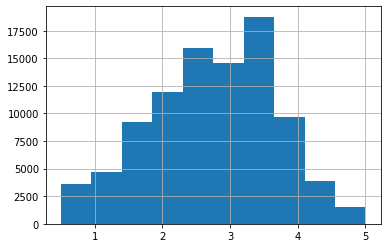

In [75]:
ratebeer['reviewScore'].hist()

<AxesSubplot:>

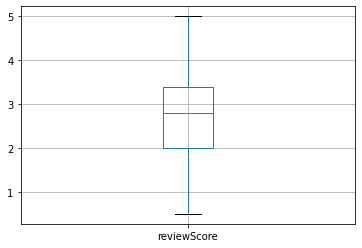

In [76]:
ratebeer[['reviewScore']].boxplot()

### preprocessing

In [77]:
def preprocessing_df(df):
    # rating 전처리
    # df['rating/apperance'] = df['review/appearance'].str.split("/").str[0].astype(int)
    # df['rating/aroma'] = df['review/aroma'].str.split("/").str[0].astype(int)
    # df['rating/palate'] = df['review/palate'].str.split("/").str[0].astype(int)
    # df['rating/taste'] = df['review/taste'].str.split("/").str[0].astype(int)
    # df['rating/overall'] = df['review/overall'].str.split("/").str[0].astype(int)
    
    # overall rating 최대치 5로 변환
    # df['rating/overall'] = df['rating/overall'] / 20 * 5
    
    # item, user, rating만 추출
    df = df[['beerID', 'profileName', 'reviewScore', 'imageUrl']]
    df.rename(columns={'beerID' : 'item', 'profileName' : 'user', 'reviewScore' : 'rating'}, inplace = True) 
    
    # 유저 리뷰 수 개산
    df['user/reviewcount'] = df.groupby('user')['user'].transform('count')
    #리뷰 수가 10개 이상인 유저만 남김 
#     df = df[(df['user/reviewcount'] > 3)]
    
#     df.drop(columns=['user/reviewcount'], inplace=True)
    
    num_users = df.user.unique().shape[0]
    num_items = df.item.unique().shape[0]
    return df, num_users, num_items

### Statistics of the Dataset

In [78]:
data, num_users, num_items = preprocessing_df(ratebeer)
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head())

number of users: 17165, number of items: 81
matrix sparsity: 0.932665
    item        user  rating  \
0  75661  Grzesiek79     1.3   
1  75661    GriZZZly     2.7   
2  75661   bdleedahl     3.3   
3  75661    DoctorHU     2.6   
4  75661     McTapps     2.5   

                                            imageUrl  user/reviewcount  
0  https://res.cloudinary.com/ratebeer/image/uplo...                55  
1  https://res.cloudinary.com/ratebeer/image/uplo...                13  
2  https://res.cloudinary.com/ratebeer/image/uplo...                31  
3  https://res.cloudinary.com/ratebeer/image/uplo...                48  
4  https://res.cloudinary.com/ratebeer/image/uplo...                49  


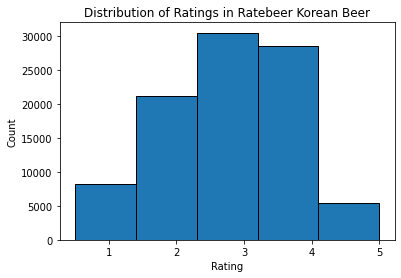

In [79]:
plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in Ratebeer Korean Beer')
plt.show()

### Label Encoding

In [80]:
user_le = LabelEncoder()
item_le = LabelEncoder()
data['user_id_idx'] = user_le.fit_transform(data['user'].values)
data['item_id_idx'] = item_le.fit_transform(data['item'].values)

# data.drop(columns=['user', 'item_id'], inplace=True)

### Loading the data

In [99]:
class BeerDataset(Dataset):
    def __init__(self, df, mode='train'):
        self.df = df
        self.mode = mode
        self.train_size = 0.8
        self.val_size = 0.1
        self.test_size = 1 - self.train_size - self.val_size 

        self.num_items = len(self.df['item_id_idx'].unique())
        self.num_users = len(self.df['user_id_idx'].unique())
        
#         n_val = int(self.num_users * self.val_size)
#         n_test = int(self.num_users * self.test_size)
        
        random.seed(42)
        np.random.seed(42)
        
#         val_indices = set(random.choices(range(self.num_users), k=n_val))
#         test_indices = set(random.choices(list(set(range(self.num_users)) - val_indices), k=n_test))
#         train_indices = set(range(self.num_users)) - val_indices - test_indices
    
#         # self.train_df, self.test_df = train_test_split(self.df, test_size=self.test_size, train_size=self.train_size, stratify = self.df['user_id_idx'].values, random_state=42)
                        
#         if self.mode == 'train':
#             self.df = self.df[self.df['user_id_idx'].isin(train_indices)]
#         elif self.mode == 'val':
#             self.df = self.df[self.df['user_id_idx'].isin(val_indices)]
#         else:
#             self.df = self.df[self.df['user_id_idx'].isin(test_indices)]
        
        # 유저 리뷰 수 개산
        self.df['user/reviewcount'] = self.df.groupby('user_id_idx')['user_id_idx'].transform('count')
        
        #리뷰 수가 4개 이상인 유저만 남김 
        self.df = self.df[(self.df['user/reviewcount'] > 3)]
        self.df.drop(columns=['user/reviewcount'], inplace=True)
        
        self.users = torch.tensor(self.df['user_id_idx'].values)
        self.items = torch.tensor(self.df['item_id_idx'].values)
        self.ratings = torch.tensor(self.df['rating'].values)
        
        self.inter_mat = self.make_inter_mat()
    
    def make_inter_mat(self):
        inter_mat = np.zeros((self.num_users, self.num_items))
        for user, item, rating in zip(self.users, self.items, self.ratings):
            inter_mat[user][item] = rating
            
        for user in self.users:
            nonzero_ind = np.where(inter_mat[user] > 0)[0]
            if len(nonzero_ind) > 3:
                valid_ind = np.random.choice(nonzero_ind, 3, replace = False)
                if self.mode == 'train':
                    inter_mat[user][valid_ind] = 0
                else:
                    inter_mat[user][np.setdiff1d(nonzero_ind, valid_ind)] = 0
            
        return inter_mat

    def __len__(self):
        # return len(self.users)
        return len(self.inter_mat)

    def __getitem__(self, index):
        # inter_mat = torch.tensor(self.inter_mat[self.users[index]]).float()
        inter_mat = torch.tensor(self.inter_mat[index]).float()

        return index, inter_mat

### Autorec Model

In [100]:
class AutoRec(nn.Module):
    def __init__(self, num_hidden, num_items, dropout=0.05):
        super(AutoRec, self).__init__()
        self.encoder = nn.Linear(num_items, num_hidden)
        self.activate = nn.Sigmoid()
        self.decoder = nn.Linear(num_hidden, num_items)
        self.dropout = nn.Dropout(dropout)

    def forward(self, mat):
        hidden = self.dropout(self.activate(self.encoder(mat)))
        pred = self.decoder(hidden)
        
        return pred

###  Model train, validcation

In [101]:
def train(model, train_iter, criterion, optm, device):
    model.train() # to train mode
    loss_sum = 0

    for _, inter_mat in train_iter:
        inter_mat = inter_mat.to(device)    

        preds = model(inter_mat)
        loss = criterion(preds, inter_mat)

        # Update
        optm.zero_grad()      # reset gradient 
        loss.backward()      # backpropagate
        optm.step()      # optimizer update
        
        loss_sum += loss.item()

    loss_avg = loss_sum / len(train_iter)

    return loss_avg

In [102]:
def validation(model, valid_iter, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum = 0

        for _, inter_mat in valid_iter:
            inter_mat = inter_mat.to(device) 

            preds = model(inter_mat)
            loss = criterion(preds, inter_mat)            

            loss_sum += loss.item()

    loss_avg = loss_sum / len(valid_iter)

    return loss_avg

In [103]:
class AutoRec_loss_fn(nn.Module):

    def __init__(self, loss_fn):
        super(AutoRec_loss_fn, self).__init__()
        self.loss_fn = loss_fn
    
    def forward(self, pred, y):
        y_for_compute = y.clone().to('cpu')
        index = np.where(y_for_compute > 0) # FILL HERE : USE np.where & y_for_compute. WARNING: y를 사용 시, y의 device가 gpu일 경우 오류 발생 #
        loss = self.loss_fn(pred[index], y[index])
        return loss

In [104]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 25
lr = 0.001
batch_size = 64

num_items = data.item_id_idx.nunique()
num_hidden = 40

In [105]:
train_dataset = BeerDataset(df=data, mode='train')
val_dataset = BeerDataset(df=data, mode='val')

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [106]:
model = AutoRec(num_hidden, num_items).to(device)
loss = AutoRec_loss_fn(nn.MSELoss().to(device)).to(device)
optm = optim.Adam(model.parameters(),lr=lr)

epoch: 0, train Loss: 2.5345, test Loss: 0.4121
epoch: 1, train Loss: 0.3832, test Loss: 0.3485
epoch: 2, train Loss: 0.3437, test Loss: 0.3279
epoch: 3, train Loss: 0.3207, test Loss: 0.3138
epoch: 4, train Loss: 0.3083, test Loss: 0.3001
epoch: 5, train Loss: 0.2938, test Loss: 0.2897
epoch: 6, train Loss: 0.2740, test Loss: 0.2717
epoch: 7, train Loss: 0.2564, test Loss: 0.2626
epoch: 8, train Loss: 0.2436, test Loss: 0.2463
epoch: 9, train Loss: 0.2250, test Loss: 0.2337
epoch: 10, train Loss: 0.2189, test Loss: 0.2241
epoch: 11, train Loss: 0.2053, test Loss: 0.2158
epoch: 12, train Loss: 0.1943, test Loss: 0.2084
epoch: 13, train Loss: 0.1830, test Loss: 0.1996
epoch: 14, train Loss: 0.1782, test Loss: 0.1929
epoch: 15, train Loss: 0.1662, test Loss: 0.1850
epoch: 16, train Loss: 0.1599, test Loss: 0.1782
epoch: 17, train Loss: 0.1497, test Loss: 0.1705
epoch: 18, train Loss: 0.1441, test Loss: 0.1675
epoch: 19, train Loss: 0.1422, test Loss: 0.1597
epoch: 20, train Loss: 0.1319,

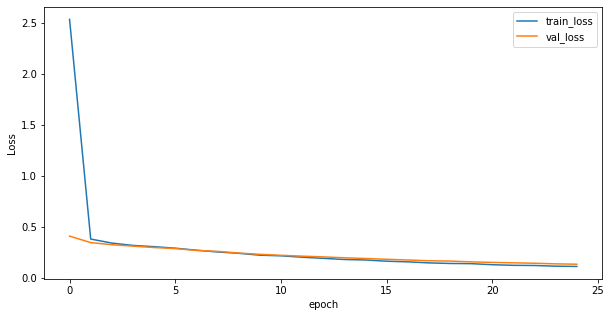

In [107]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    train_loss = train(model, train_dataloader, loss, optm, device)
    val_loss = validation(model, val_dataloader, loss, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'epoch: {epoch}, train Loss: {train_loss:.4f}, test Loss: {val_loss:.4f}')

plt.figure(figsize=(10,5))
plt.plot(train_losses,label="train_loss")
plt.plot(val_losses,label="val_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [108]:
train_dataset.inter_mat.shape

(17165, 81)

In [109]:
PATH = '../model/autorec_exp_rmse.pt'
torch.save(model.state_dict(), PATH)

## inference

### 모델 불러오기

In [110]:
model = AutoRec(num_hidden, num_items).to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### 평가지표 함수

In [86]:
def ndcg_k(actual, predicted, topk):
    res = 0
    for user_id in range(len(actual)):
        k = min(topk, len(actual[user_id]))
        idcg = idcg_k(k)
        dcg_k = sum(
            [
                int(predicted[user_id][j] in set(actual[user_id])) / math.log(j + 2, 2)
                for j in range(topk)
            ]
        )
        res += dcg_k / idcg
    return res / float(len(actual))

# Calculates the ideal discounted cumulative gain at k
def idcg_k(k):
    res = sum([1.0 / math.log(i + 2, 2) for i in range(k)])
    if not res:
        return 1.0
    else:
        return res

def recall_at_k(actual, predicted, topk):
    sum_recall = 0.0
    num_users = len(predicted)
    true_users = 0
    for i in range(num_users):
        act_set = set(actual[i])
        pred_set = set(predicted[i][:topk])
        if len(act_set) != 0:
            sum_recall += len(act_set & pred_set) / float(len(act_set))
            true_users += 1
    return sum_recall / true_users

In [87]:
def inference(model, test_iter, test_matrix, device, topk = 4):
    pred_list = None
    answer_list = None
    with torch.no_grad():
        model.eval()

        for i, (user_ids, inter_mat) in enumerate(test_iter):
            inter_mat = inter_mat.to(device)
            
            rating_pred = model(inter_mat)
            
            rating_pred = rating_pred.cpu().data.numpy().copy()
            
            batch_user_index = user_ids.cpu().numpy()
            answers = test_matrix.argsort(axis = 1)[batch_user_index, -topk:][:, ::-1]
            # rating_pred[test_matrix[batch_user_index] > 0] = 0
            
            ind = np.argpartition(rating_pred, -topk)[:, -topk:]
            
            arr_ind = rating_pred[np.arange(len(rating_pred))[:, None], ind]

            arr_ind_argsort = np.argsort(arr_ind)[np.arange(len(rating_pred)), ::-1]

            batch_pred_list = ind[
                np.arange(len(rating_pred))[:, None], arr_ind_argsort
            ]

            if i == 0:
                pred_list = batch_pred_list
                answer_list = answers
            else:
                pred_list = np.append(pred_list, batch_pred_list, axis=0)
                answer_list = np.append(
                        answer_list, answers, axis=0
                )
            
        recall = recall_at_k(answer_list, pred_list, topk)
        ndcg = ndcg_k(answer_list, pred_list, topk)
        
        print(f'recall@{topk} = {recall}, ndcg@{topk} = {ndcg}')
    return pred_list, answer_list

In [88]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 25
lr = 0.001
batch_size = 1

num_items = data.item_id_idx.nunique()
num_hidden = 40

In [89]:
test_dataset = BeerDataset(df=data, mode='test')

test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

test_matrix = test_dataset.inter_mat

### inference 수행

In [59]:
pred_list, answer_list = inference(model, test_dataloader, test_matrix, device, topk=4)

recall@4 = 0.05295659772793475, ndcg@4 = 0.061438824849315406


In [60]:
# test 데이터 user 목록
test_dataset.df.user_id_idx.unique()

array([14420,  2619, 12238, ...,  7819, 14540,  3600])

In [61]:
# 모델 예측 선호 맥주 top4
pred_list[14420]

array([58, 55, 19,  9])

In [62]:
# 유저 실제 선호 맥주 top4
answer_list[14420]

array([58, 19, 55, 15])

In [63]:
test_matrix[14420]

array([1.9, 0. , 0. , 1.5, 2.2, 2.1, 3.5, 1.9, 1.4, 3.4, 2.8, 0. , 0. ,
       3.3, 0. , 3.6, 1.7, 1.6, 3.5, 3.8, 2.8, 2.2, 0. , 2.9, 3. , 3. ,
       3.4, 3.3, 0. , 0. , 2. , 2.4, 0. , 1.8, 0. , 2.3, 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 3.2, 0. , 0. , 0. , 0. , 3. ,
       3.1, 0. , 1.9, 3.7, 2. , 0. , 3.8, 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 3. , 1.8, 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. ])

### 웹사이트 inference

In [252]:
show_list = np.random.choice(81, 30, replace = False)

In [253]:
show_list

array([26,  8, 45, 12, 53, 21, 44, 43,  3, 71, 49, 29, 11, 66, 54, 55, 15,
       30, 14, 18, 39, 63, 68, 19, 79, 42,  4, 20, 76, 22])

In [254]:
x_test = torch.zeros(81)
x_test

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [255]:
for beer in show_list:
    x_test[beer] = random.choice(rating_list)
x_test

tensor([0.0000, 0.0000, 0.0000, 2.8000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000,
        0.0000, 0.0000, 0.5000, 5.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000,
        2.8000, 2.8000, 5.0000, 2.8000, 2.8000, 0.0000, 0.0000, 0.0000, 0.5000,
        0.0000, 0.0000, 2.8000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 5.0000, 0.0000, 0.0000, 0.5000, 2.8000, 0.5000,
        2.8000, 0.0000, 0.0000, 0.0000, 5.0000, 0.0000, 0.0000, 0.0000, 5.0000,
        0.5000, 5.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.5000, 0.0000, 0.0000, 5.0000, 0.0000, 0.5000, 0.0000, 0.0000, 5.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 5.0000, 0.0000, 0.0000, 2.8000, 0.0000])

In [256]:
# show_df = data[data['item_id_idx'].isin(show_list)]

In [257]:
# not_show_list = np.delete(np.arange(81), show_list)
# not_show_list

array([ 0,  1,  2,  5,  6,  7,  9, 10, 13, 16, 17, 23, 24, 25, 27, 28, 31,
       32, 33, 34, 35, 36, 37, 38, 40, 41, 46, 47, 48, 50, 51, 52, 56, 57,
       58, 59, 60, 61, 62, 64, 65, 67, 69, 70, 72, 73, 74, 75, 77, 78, 80])

In [258]:
# for i in not_show_list:
#     style = data[data['item_id_idx'] == i]['label'].unique()[0]
#     rating = show_df[show_df['label'] == style]['rating'].mean()
#     if np.isnan(rating):
#         rating = rating_list[1] # style로 점수를 채울 수 없는 경우 몰라요로 채운다
#     x_test[i] = rating
# x_test

tensor([2.1645, 2.8000, 2.1645, 2.8000, 0.5000, 2.8000, 3.1620, 2.1645, 0.5000,
        3.5909, 2.1645, 0.5000, 5.0000, 2.5330, 0.5000, 0.5000, 2.1645, 2.1645,
        2.8000, 2.8000, 5.0000, 2.8000, 2.8000, 3.1620, 3.5909, 3.5909, 0.5000,
        2.8000, 2.1645, 2.8000, 0.5000, 2.1645, 2.8000, 2.1645, 2.1645, 2.1645,
        2.5330, 2.5330, 2.1645, 5.0000, 2.1645, 2.1645, 0.5000, 2.8000, 0.5000,
        2.8000, 3.1620, 2.1645, 2.8000, 5.0000, 2.1645, 2.8000, 3.5909, 5.0000,
        0.5000, 5.0000, 2.5330, 2.8000, 3.5131, 3.1620, 2.1645, 3.5909, 2.5330,
        0.5000, 2.1645, 2.8000, 5.0000, 2.8000, 0.5000, 2.8000, 2.1645, 5.0000,
        2.8000, 2.8000, 2.8000, 3.0375, 5.0000, 2.8000, 3.5909, 2.8000, 3.5909])

In [128]:
# 웹사이트 input
# x_test = torch.tensor([1.9, 0. , 0. , 1.5, 2.2, 2.1, 3.5, 1.9, 1.4, 3.4, 2.8, 0. , 0. ,
#        3.3, 0. , 3.6, 1.7, 1.6, 3.5, 3.8, 2.8, 2.2, 0. , 2.9, 3. , 3. ,
#        3.4, 3.3, 0. , 0. , 2. , 2.4, 0. , 1.8, 0. , 2.3, 0. , 0. , 0. ,
#        0. , 0. , 0. , 0. , 0. , 0. , 0. , 3.2, 0. , 0. , 0. , 0. , 3. ,
#        3.1, 0. , 1.9, 3.7, 2. , 0. , 3.8, 0. , 0. , 0. , 0. , 0. , 0. ,
#        0. , 0. , 0. , 0. , 0. , 3. , 1.8, 0. , 0. , 0. , 0. , 0. , 0. ,
#        0. , 0. , 0. ]).to(device)

num_item = data['item'].nunique()

rating_list = [5.0, 2.8, 0.5] # 좋아요, 몰라요, 싫어요
show_list = np.random.choice(num_item, 30, replace=False) # 임의로 30개 추출
x_test = torch.zeros(num_item).to(device) # 0으로 초기화

for beer in show_list:
    x_test[beer] = random.choice(rating_list) # 30개에 대해서 임의로 평가
    
# show_df = data[data['item_id_idx'].isin(show_list)]
    
# not_show_list = np.delete(np.arange(81), show_list)


# for i in not_show_list:
#     style = data[data['item_id_idx'] == i]['label'].unique()[0]
#     rating = show_df[show_df['label'] == style]['rating'].mean()
    
#     if np.isnan(rating):
#         rating = rating_list[1] # style로 점수를 채울 수 없는 경우 몰라요로 채운다
#     x_test[i] = rating
#     # print(rating)

# 추천 맥주 개수
topk = 4

# 모델 에측 맥주 평점
rating_pred = model(x_test)

rating_pred = rating_pred.cpu().data.numpy().copy()
# print(rating_pred)

# batch_user_index = user_ids.cpu().numpy()
answers = x_test.cpu().numpy().argsort()[-topk:][::-1]

# user가 리뷰를 남긴 맥주 추천하고 싶지 않을 때 사용

# if novelty:
# 좋아요, 싫어요로 직접 평가한 맥주는 다시 추천하지 않도록 설정
rating_pred[x_test.cpu().numpy() == rating_list[0]] = 0
rating_pred[x_test.cpu().numpy() == rating_list[2]] = 0
# print(rating_pred)

# topk 맥주 index
ind = np.argpartition(rating_pred, -topk)[-topk:]
# print(ind)

# topk 맥주 index별 평점
arr_ind = rating_pred[ind]
# print(arr_ind)

# 평점 기준으로 내림차순으로 정렬
arr_ind_argsort = np.argsort(arr_ind)[::-1]
# print(arr_ind_argsort)

# rating 내림차순 모델 예측 topk 맥주 index 
topk_pred_list = ind[arr_ind_argsort]
print(topk_pred_list)

# rating 내림차순 모델 예측 맥주 평점 중 topk개
topk_rating_list = rating_pred[topk_pred_list] #rating_pred[np.arange(len(rating_pred))[:, None], ind]
print(topk_rating_list)

[77 55 47 78]
[5.474941  5.036343  4.9859796 4.706812 ]


In [129]:
# 모델 예측 선호 맥주 top4
topk_pred_list

array([77, 55, 47, 78])

In [130]:
# 유저 실제 선호 맥주 top4
answers

array([14, 19, 51, 12])

In [131]:
rating_pred[topk_pred_list]

array([5.474941 , 5.036343 , 4.9859796, 4.706812 ], dtype=float32)

In [132]:
label_list = ['good', 'unknown', 'bad']

for i, rating in enumerate(rating_list):
    print(label_list[i])
    print(list(sorted([rating_pred[i] for i in np.where(x_test.cpu().numpy() == rating)[0]], reverse=True)))
    print()

good
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

unknown
[3.6709335, 3.1888082, 3.0101006, 2.767786, 2.7264724, 2.673909, 2.6226504, 2.5643942, 2.447268, 1.8542646]

bad
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]



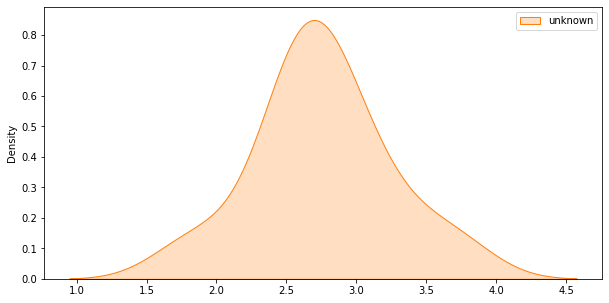

In [133]:
label_list = ['good', 'unknown', 'bad']

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for i, rating in enumerate(rating_list):
    
    ax = sns.kdeplot(sorted([rating_pred[i] for i in np.where(x_test.cpu().numpy() == rating)[0]], reverse=True), label = label_list[i], fill = True)

plt.legend()
plt.show()

<AxesSubplot:ylabel='Count'>

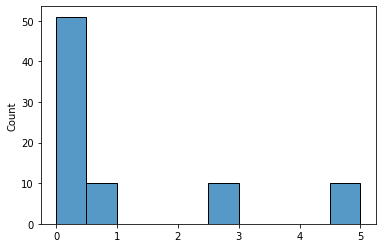

In [134]:
sns.histplot(x_test.cpu().numpy(), bins = 10)

<AxesSubplot:ylabel='Count'>

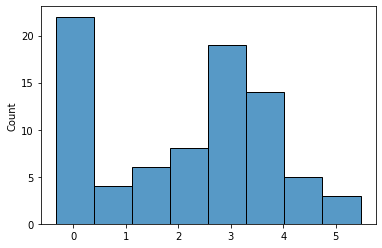

In [137]:
sns.histplot(rating_pred)

In [135]:
# 모델 예측 rating 점수
rating_pred

array([ 0.99346924,  3.6709335 ,  2.8697045 ,  0.        ,  1.6916649 ,
        2.8781707 ,  2.9582796 ,  1.1535127 ,  0.        ,  3.4468086 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        2.0098047 ,  0.67180765, -0.32936156,  3.3641593 ,  0.        ,
        0.        ,  0.61583346,  2.8828557 ,  2.3927727 ,  2.673909  ,
        3.6149137 ,  2.5003119 ,  2.6523101 ,  0.        ,  1.3296223 ,
        3.8540273 ,  2.0583663 ,  0.40723187,  1.7148998 ,  0.        ,
        1.8085371 ,  3.2907684 ,  3.8639297 ,  2.803295  ,  2.7264724 ,
        0.        ,  3.8453026 ,  2.8378022 ,  1.8542646 ,  3.5269158 ,
        2.656327  ,  0.        ,  4.9859796 ,  3.3760717 ,  2.5643942 ,
        2.767786  ,  0.        ,  3.7268033 ,  0.        ,  2.3546154 ,
        5.036343  ,  3.2930002 ,  3.0101006 ,  3.8853717 ,  0.        ,
        0.        ,  4.5510597 ,  3.2604358 ,  4.517399  ,  2.6226504 ,
        0.        ,  1.5446908 ,  2.5855799 ,  2.447268  ,  0.  

In [136]:
x_test

tensor([0.0000, 2.8000, 0.0000, 5.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000,
        0.0000, 5.0000, 5.0000, 5.0000, 0.5000, 5.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 5.0000, 0.5000, 0.0000, 0.0000, 0.0000, 2.8000, 0.0000, 0.0000,
        0.0000, 5.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000,
        0.0000, 0.0000, 0.0000, 2.8000, 0.5000, 0.0000, 0.0000, 2.8000, 0.0000,
        0.0000, 5.0000, 0.0000, 0.0000, 2.8000, 2.8000, 5.0000, 0.0000, 5.0000,
        0.0000, 0.0000, 0.0000, 2.8000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000,
        0.0000, 2.8000, 0.5000, 0.0000, 0.0000, 2.8000, 0.5000, 0.0000, 0.0000,
        0.0000, 2.8000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')

In [138]:
# np.where(x_test.cpu().numpy() == 0.5)[0]

array([ 8, 13, 20, 34, 40, 59, 60, 65, 69, 76])

In [36]:
# set(np.where(x_test.cpu().numpy() == 0.5)[0]) & set(np.where(rating_pred < 2.0)[0])

{2, 9, 12, 24, 28, 30, 37, 42, 45, 48, 52, 56, 64, 72, 76}

In [48]:
# rating_pred[21]

-4.3385754

In [139]:
# image url
data[data['item_id_idx'].isin(topk_pred_list)]['imageUrl'].unique()

array(['https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_614833',
       'https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_36249',
       'https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_75071',
       'https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_621308'],
      dtype=object)

In [140]:
# 맥주 이름
data[data['item_id_idx'].isin(topk_pred_list)]['item'].unique()

array([614833,  36249,  75071, 621308])

### 평가지표 점수

In [141]:
def ndcg_k_inf(actual, predicted, topk):
    res = 0
    k = min(topk, len(actual))
    idcg = idcg_k(k)
    dcg_k = sum(
        [
            int(predicted[j] in set(actual)) / math.log(j + 2, 2)
            for j in range(topk)
        ]
    )
    res += dcg_k / idcg
    return res / float(len(actual))

# Calculates the ideal discounted cumulative gain at k
def idcg_k(k):
    res = sum([1.0 / math.log(i + 2, 2) for i in range(k)])
    if not res:
        return 1.0
    else:
        return res

def recall_at_k_inf(actual, predicted, topk):
    act_set = set(actual)
    pred_set = set(predicted[:topk])
    if len(act_set) != 0:
        sum_recall = len(act_set & pred_set) / float(len(act_set))
        
    return sum_recall

In [142]:
recall_at_k_inf(answers, topk_pred_list, 4)

0.0

In [143]:
ndcg_k_inf(answers, topk_pred_list, 4)

0.0

In [144]:
data

,item,user,rating,imageUrl,user/reviewcount,user_id_idx,item_id_idx
0,75661,Grzesiek79,1.3,https://res.cloudinary.com/ratebeer/image/uplo...,55,3051,56
1,75661,GriZZZly,2.7,https://res.cloudinary.com/ratebeer/image/uplo...,13,3028,56
2,75661,bdleedahl,3.3,https://res.cloudinary.com/ratebeer/image/uplo...,31,8450,56
3,75661,DoctorHU,2.6,https://res.cloudinary.com/ratebeer/image/uplo...,48,2153,56
4,75661,McTapps,2.5,https://res.cloudinary.com/ratebeer/image/uplo...,49,4783,56
...,...,...,...,...,...,...,...
93615,703,Bov,3.0,https://res.cloudinary.com/ratebeer/image/uplo...,46,1215,10
93616,703,sallyclub99,4.2,https://res.cloudinary.com/ratebeer/image/uplo...,7,15196,10
93617,703,kublai3,2.7,https://res.cloudinary.com/ratebeer/image/uplo...,6,12689,10
93618,703,Aubrey,3.3,https://res.cloudinary.com/ratebeer/image/uplo...,23,520,10


In [40]:
data.to_csv('../data/ratebeer_label_encoding.csv', index = False)